In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os
import talib
import factors
import labeling
from tree import train_ensemble, evaluate_ensemble, get_predicted_label_sequence

## Data Loading

In [2]:
data_dir = r"D:\360MoveData\Users\liujunyuan\Desktop\QTS\Crypto_trading_technical_indicators\data\cpt_5min\k_data"

pkl_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

data_dict = {}
for file in pkl_files:
    file_path = os.path.join(data_dir, file)
    data_dict[file] = pd.read_pickle(file_path)


In [3]:
file_list = ['ADAUSD.pkl', 'ATOMUSD.pkl', 'AVAXUSD.pkl', 'BNBUSD.pkl', 'BTCUSD.pkl',
             'DOGEUSD.pkl', 'ETHUSD.pkl', 'LTCUSD.pkl', 'SHIBUSD.pkl', 'SOLUSD.pkl', 'VETUSD.pkl']

names = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'ETH', 'LTC', 'SHIB', 'SOL', 'VETI']

for name, file in zip(names, file_list):
    globals()[name] = data_dict.get(file)
BTC.head()

,open,high,low,close,preclose,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
date,,,,,,,,,,,,
2022-01-01 06:00:00,47190.56,47241.08,47119.92,47119.92,NaN,2.436750,1641017099999,114931.6736,153,0.57991700,27364.2666,0
2022-01-01 06:05:00,47115.80,47280.38,47108.32,47261.43,47119.92,1.418390,1641017399999,66979.3455,113,0.74723500,35294.5064,0
2022-01-01 06:10:00,47260.56,47331.57,47249.63,47311.32,47261.43,1.963671,1641017699999,92861.0111,134,1.61761000,76491.6220,0
2022-01-01 06:15:00,47298.17,47298.17,47190.28,47209.46,47311.32,2.039986,1641017999999,96429.3426,79,0.70107400,33117.6099,0
2022-01-01 06:20:00,47208.81,47228.06,47169.77,47175.65,47209.46,0.207595,1641018299999,9797.1701,55,0.06055400,2857.7020,0


## Factors Construction

#### Importing the talib library, we developed a script called factors.py to compute 124 technical indicators, and we performed the calculations using high-frequency Bitcoin closing price data.

In [4]:
start = "2022-01-01 06:00:00"
end = "2024-12-31 06:00:00"

df_with_indicators = factors.compute_technical_indicators(BTC, start, end)
df_result = df_with_indicators.iloc[120:].copy()

labels = labeling.generate_labels(BTC, price_col='close')
labels = labels.iloc[120:]


df_final = df_result.copy()
df_final['label'] = labels
df_final = df_final.infer_objects(copy=False)
pd.set_option('future.no_silent_downcasting', True)
df_final.fillna(0, inplace=True)
print(df_final.tail())

                         open      high       low     close  preclose  \
date                                                                    
2023-07-14 02:35:00  25301.01  25468.59  25101.01  25101.01  25301.01   
2023-07-14 02:40:00  25101.01  26459.02  25001.00  25196.00  25101.01   
2023-07-14 02:45:00  25241.24  25493.65  25001.02  25115.01  25196.00   
2023-07-14 02:50:00  25199.29  25241.24  25000.00  25025.00  25115.01   
2023-07-14 02:55:00  25025.00  25366.91  24900.00  25073.21  25025.00   

                      volume     close_time quote_asset_volume  \
date                                                             
2023-07-14 02:35:00  2.75876  1689302399999     69555.21985510   
2023-07-14 02:40:00  6.24542  1689302699999    158555.79135570   
2023-07-14 02:45:00  2.08130  1689302999999     52313.41949270   
2023-07-14 02:50:00  2.83007  1689303299999     70992.71200950   
2023-07-14 02:55:00  6.33031  1689303599999    158289.62984610   

                     numb

## Model Training

#### Based on the approach outlined in the paper, we partitioned the data into training and test sets in a 3:1 ratio, used the decision tree model to predict the intervals of currency returns, and employed an "average model" comprising 100 independently trained decision trees to generate the final predictions.

In [5]:
train_size = int(len(df_final) * 0.75)
train_df = df_final.iloc[:train_size].copy()
test_df = df_final.iloc[train_size:].copy()

print("Training Dataset Size:", train_df.shape[0])
print("Test Dataset Size:", test_df.shape[0])

Training Dataset Size: 120558
Test Dataset Size: 40187


In [6]:
trees = train_ensemble(train_df)

train_acc = evaluate_ensemble(trees, train_df)
print("Train Accuracy:", train_acc)

test_acc = evaluate_ensemble(trees, test_df)
print("Test Accuracy:", test_acc)

predicted_labels_series = get_predicted_label_sequence(trees, test_df)
test_df = test_df.copy()
test_df['predicted_label'] = predicted_labels_series
test_df[['label', 'predicted_label']].tail()

Training trees: 100%|██████████| 100/100 [08:38<00:00,  5.18s/it]


Train Accuracy: 1.0
Test Accuracy: 0.28942195237265783


,label,predicted_label
date,,
2023-07-14 02:35:00,2,2
2023-07-14 02:40:00,-2,-2
2023-07-14 02:45:00,-2,2
2023-07-14 02:50:00,2,2
2023-07-14 02:55:00,0,2


## Strategy Performance Analysis

#### In order to visually assess the volatility of Bitcoin asset prices over the sample period, we have produced the following descriptive statistics table. The reported variables include the average daily return, daily volatility, annualized volatility, the annualized geometric average of daily returns (rG), the annualized arithmetic average of daily returns (rA), and the information ratios based on these two annualized average returns. The statistical results indicate that Bitcoin exhibited low returns and high risk during the overall sample period, with an average daily return of approximately -0.067%, an annualized volatility close to 59%, and negative annualized returns, suggesting that the market was generally in a depressed state. The high volatility implies significant market risk and reflects the inherent risk-return characteristics, offering important insights for investors in risk management and strategy adjustment.

In [7]:
def compute_return_stats(df, label='returns'):
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
        
    daily_close = df['close'].resample('D').last().dropna()
    daily_returns = daily_close.pct_change().dropna()
    
    r_mean = daily_returns.mean()
    r_std = daily_returns.std()
    annualized_vol = r_std * np.sqrt(365)
    
    rG = (daily_returns.add(1).prod())**(365/len(daily_returns)) - 1
    rA = (1 + r_mean)**365 - 1

    ir_geom = rG / annualized_vol if annualized_vol != 0 else np.nan
    ir_arith = rA / annualized_vol if annualized_vol != 0 else np.nan

    stats = {
        'Average Daily Return': r_mean,
        'Daily Volatility': r_std,
        'Annualized Volatility': annualized_vol,
        'Annualized Geometric Average Return (rG)': rG,
        'Annualized Arithmetic Average Return (rA)': rA,
        'Information Ratio (rG)': ir_geom,
        'Information Ratio (rA)': ir_arith
    }
    return pd.Series(stats)


full_stats = compute_return_stats(df_final)
train_stats = compute_return_stats(train_df)
test_stats = compute_return_stats(test_df)

summary_table = pd.concat([full_stats, train_stats, test_stats], axis=1)
summary_table.columns = ['Full Sample', 'Training Sample', 'Test Sample']
print("Return Summary Statistics:")
display(summary_table)

Return Summary Statistics:


,Full Sample,Training Sample,Test Sample
Average Daily Return,-0.000671,-0.001126,0.000859
Daily Volatility,0.030906,0.032669,0.024812
Annualized Volatility,0.590459,0.624135,0.474039
Annualized Geometric Average Return (rG),-0.343160,-0.455487,0.225854
Annualized Arithmetic Average Return (rA),-0.217338,-0.337234,0.368210
Information Ratio (rG),-0.581175,-0.729789,0.476446
Information Ratio (rA),-0.368084,-0.540322,0.776751


#### By reasonably partitioning Bitcoin return intervals into five segments: [-∞, -0.1), [-0.1, -0.02), [-0.02, 0.02), [0.02, 0.1), and [0.1, +∞), we are able to maintain roughly equal sample sizes in both the training and testing sets, thereby minimizing the risk of overfitting due to sample imbalance.

In [8]:
def count_labels(df):
    counts = df['label'].value_counts().sort_index()
    return counts

full_label_counts = count_labels(df_final)
train_label_counts = count_labels(train_df)
test_label_counts = count_labels(test_df)

trend_table = pd.DataFrame({
    'Full Sample': full_label_counts,
    'Training Sample': train_label_counts,
    'Test Sample': test_label_counts
})
trend_table.index.name = 'Label'
print("Trend Statistics:")
display(trend_table)

Trend Statistics:


,Full Sample,Training Sample,Test Sample
Label,,,
-2,29059,23507,5552
-1,36914,26753,10161
0,28638,19777,8861
1,37147,27121,10026
2,28987,23400,5587


#### In the table below, we compiled both in-sample and out-of-sample backtest results and plotted the corresponding cumulative PnL charts. The results show that, in terms of win ratio, the relatively simple structure of tree models leads to severe overfitting when applied to large volumes of high-frequency data, as evidenced by an in-sample win rate of 1.0 versus an out-of-sample win rate just above 0.5. The model’s win_ratio/loss_ratio is around 1.2, which is not very significant and indicates insufficient strategy effectiveness. Moreover, the cumulative PnL curve reveals that although the strategy can achieve higher final returns than a hold-and-wait approach when ignoring transaction costs, it experiences significant return fluctuations and extremely high maximum drawdowns. To further improve the strategy, we will conduct additional analysis and screening of the profitability of the 124 indicators and optimize the trading strategy by incorporating prediction models better suited for high-frequency strategies.

In [9]:
# 1. In-sample (Training set) performance statistics
# ----------------------------
train_perf = train_df.copy()
train_perf['next_return'] = train_perf['close'].shift(-1) / train_perf['close'] - 1
train_perf = train_perf.dropna()  # Remove the last row (no next period)

# Get ensemble predicted labels for training set (labels: -2, -1, 0, 1, 2)
predicted_train = get_predicted_label_sequence(trees, train_perf)

# Define trading signals:
# Long signals: 1 and 2; Short signals: -2 and -1.
long_signals = [1, 2]
short_signals = [-2, -1]

performance_train = {}

# For long signals: win_ratio = proportion with next_return > 0, loss_ratio = proportion with next_return < 0.
for signal in long_signals:
    mask = (predicted_train == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (train_perf.loc[mask, 'next_return'] > 0).mean()
        loss_ratio = (train_perf.loc[mask, 'next_return'] < 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_train[signal] = {'n_trades': n_trades, 
                                 'win_ratio': win_ratio, 
                                 'loss_ratio': loss_ratio}

# For short signals: win_ratio = proportion with next_return < 0, loss_ratio = proportion with next_return > 0.
for signal in short_signals:
    mask = (predicted_train == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (train_perf.loc[mask, 'next_return'] < 0).mean()
        loss_ratio = (train_perf.loc[mask, 'next_return'] > 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_train[signal] = {'n_trades': n_trades, 
                                 'win_ratio': win_ratio, 
                                 'loss_ratio': loss_ratio}

perf_train_df = pd.DataFrame(performance_train).T.sort_index()
print("In-sample (Training set) trading performance (n_trades, win_ratio, loss_ratio):")
display(perf_train_df)

In-sample (Training set) trading performance (n_trades, win_ratio, loss_ratio):


,n_trades,win_ratio,loss_ratio
-2,23506.0,1.0,0.0
-1,26753.0,1.0,0.0
1,27121.0,1.0,0.0
2,23400.0,1.0,0.0


In [10]:
# 2. Out-of-sample (Test set) performance and simulated trading
# ----------------------------
test_perf = test_df.copy()
test_perf['next_return'] = test_perf['close'].shift(-1) / test_perf['close'] - 1
test_perf = test_perf.dropna()

# Get ensemble predicted labels for test set
predicted_test = get_predicted_label_sequence(trees, test_perf)

performance_test = {}

for signal in long_signals:
    mask = (predicted_test == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (test_perf.loc[mask, 'next_return'] > 0).mean()
        loss_ratio = (test_perf.loc[mask, 'next_return'] < 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_test[signal] = {'n_trades': n_trades, 
                                'win_ratio': win_ratio, 
                                'loss_ratio': loss_ratio}

for signal in short_signals:
    mask = (predicted_test == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (test_perf.loc[mask, 'next_return'] < 0).mean()
        loss_ratio = (test_perf.loc[mask, 'next_return'] > 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_test[signal] = {'n_trades': n_trades, 
                                'win_ratio': win_ratio, 
                                'loss_ratio': loss_ratio}

perf_test_df = pd.DataFrame(performance_test).T.sort_index()
print("Out-of-sample (Test set) trading performance (n_trades, win_ratio, loss_ratio):")
display(perf_test_df)

Out-of-sample (Test set) trading performance (n_trades, win_ratio, loss_ratio):


,n_trades,win_ratio,loss_ratio
-2,6587.0,0.509944,0.482010
-1,13031.0,0.527435,0.459827
1,12966.0,0.514962,0.469227
2,5297.0,0.533698,0.457240


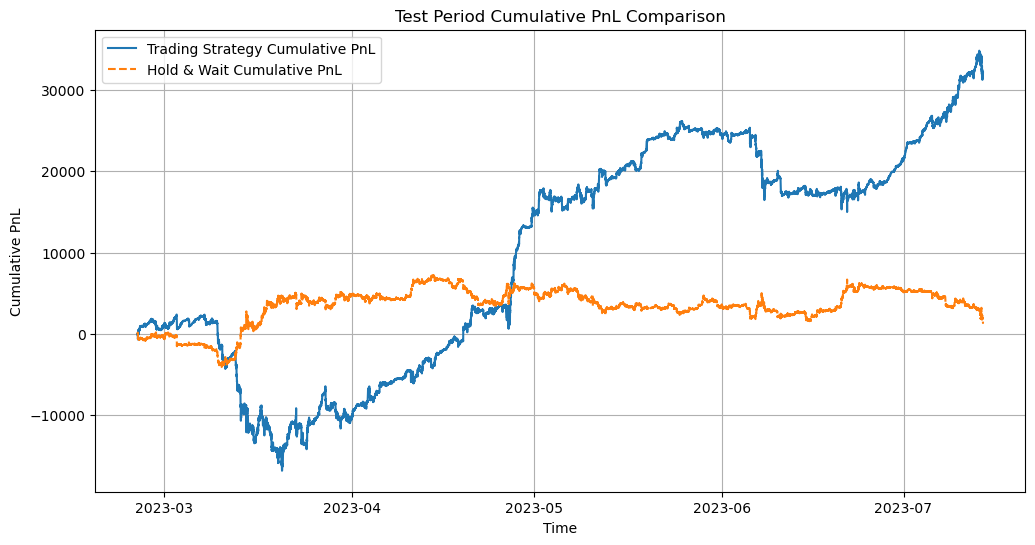

In [11]:
test_trading = test_df.copy()
test_trading['position'] = predicted_test.astype(float)
test_trading['pnl'] = test_trading['position'] * (test_trading['close'].shift(-1) - test_trading['close'])
test_trading = test_trading.dropna(subset=['pnl'])
test_trading['cumulative_pnl'] = test_trading['pnl'].cumsum()

# ----------------------------
# 2. Hold & Wait Strategy Simulation
# ----------------------------
test_hold = test_df.copy()
initial_price = test_hold['close'].iloc[0]
test_hold['pnl'] = test_hold['close'] - initial_price

plt.figure(figsize=(12, 6))
plt.plot(test_trading.index, test_trading['cumulative_pnl'], label='Trading Strategy Cumulative PnL')
plt.plot(test_hold.index, test_hold['pnl'], label='Hold & Wait Cumulative PnL', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Test Period Cumulative PnL Comparison')
plt.legend()
plt.grid(True)
plt.show()

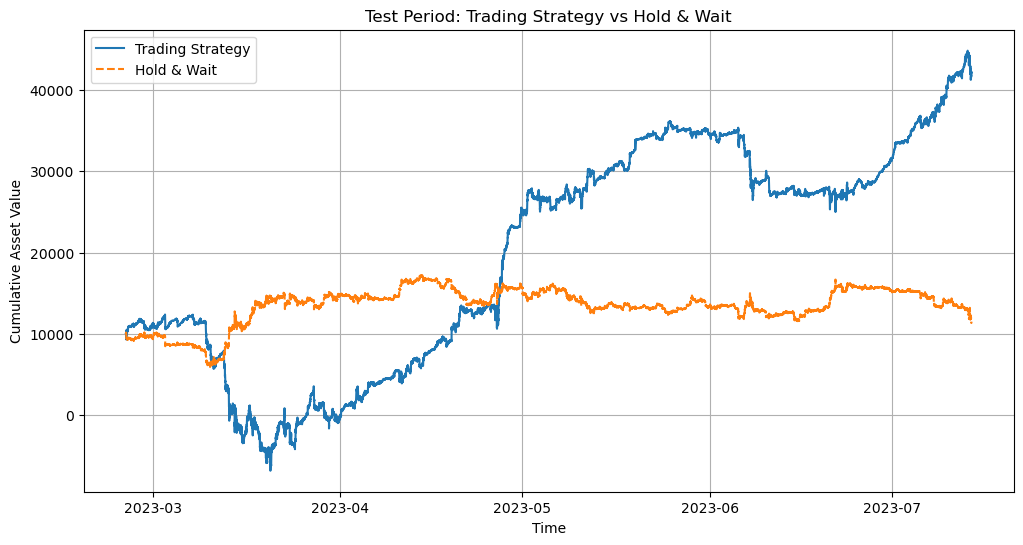

In [12]:
def simulate_trading(series_close, series_signal, initial_cash=10000, fee_rate=0.0002):
    """
    Simulate trading based on predicted signals.
    
    Parameters:
      series_close: pd.Series, asset close prices (indexed by time)
      series_signal: pd.Series, trading signals (predicted label, with values in {-2, -1, 0, 1, 2})
      initial_cash: initial cash amount (default 10000)
      fee_rate: transaction fee rate applied on both entry and exit
      
    Trading rule (per period):
      - If signal > 0: buy 'signal' units at current close, and sell at next period's close.
      - If signal < 0: short |signal| units at current close, and cover at next period's close.
      - If signal == 0: do nothing.
      
    Fee is applied on both the entry and exit transactions.
    
    Returns:
      time_index: index corresponding to each trade (using current period index)
      asset_values: list of cumulative asset values after each trade.
    """
    cash = initial_cash
    asset_values = []
    
    # Combine close prices and signals into a DataFrame
    df = pd.concat([series_close, series_signal], axis=1)
    df.columns = ["close", "Signal"]
    
    # We simulate trades from period 0 to period N-2 (since last period has no next close)
    for i in range(len(df) - 1):
        price = df["close"].iloc[i]
        signal = df["Signal"].iloc[i]
        # If signal is 0, no trade; asset value remains unchanged.
        if signal != 0:
            next_price = df["close"].iloc[i+1]
            # Compute trade value = abs(signal) * price
            trade_value_entry = abs(signal) * price
            fee_entry = trade_value_entry * fee_rate
            trade_value_exit = abs(signal) * next_price
            fee_exit = trade_value_exit * fee_rate
            # For a long trade (signal > 0): pnl = signal*(next_price - price) - fees
            # For a short trade (signal < 0): pnl = abs(signal)*(price - next_price) - fees
            if signal > 0:
                pnl = signal * (next_price - price) - fee_entry - fee_exit
            else:
                pnl = abs(signal) * (price - next_price) - fee_entry - fee_exit
            cash += pnl
        asset_values.append(cash)
    
    # For plotting purposes, use the index from period 0 to len(df)-1
    time_index = df.index[:-1]
    return time_index, asset_values

def simulate_hold(series_close, initial_cash=10000, fee_rate=0.0002):
    """
    Simulate a hold & wait strategy: buy 1 unit at the beginning and hold until the end.
    
    Parameters:
      series_close: pd.Series, asset close prices (indexed by time)
      initial_cash: initial cash (default 10000)
      fee_rate: transaction fee rate (applied on entry and exit)
      
    Returns:
      time_index: same as series_close index
      asset_values: cumulative asset values (cash + position * close price).
    """
    # Buy 1 unit at the first period
    initial_price = series_close.iloc[0]
    trade_value_entry = initial_price
    fee_entry = trade_value_entry * fee_rate
    # Cash after purchase:
    cash = initial_cash - (trade_value_entry + fee_entry)
    # Position is 1 unit
    position = 1
    asset_values = []
    for price in series_close:
        asset_value = cash + position * price
        asset_values.append(asset_value)
    return series_close.index, asset_values

# ----------------------------
# Using our test set and predicted label (predicted_test)
# ----------------------------
# For our simulation, ensure test_df has no NaN in 'close'
test_series_close = test_df['close']

# Simulate our trading strategy based on predicted signals
time_idx, strategy_asset = simulate_trading(test_series_close, predicted_test, initial_cash=10000, fee_rate=0.0)

# Simulate hold & wait strategy
hold_time_idx, hold_asset = simulate_hold(test_series_close, initial_cash=10000, fee_rate=0.0)

# Plot cumulative asset curves
plt.figure(figsize=(12, 6))
plt.plot(time_idx, strategy_asset, label='Trading Strategy')
plt.plot(hold_time_idx, hold_asset, label='Hold & Wait', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cumulative Asset Value')
plt.title('Test Period: Trading Strategy vs Hold & Wait')
plt.legend()
plt.grid(True)
plt.show()